<a href="https://colab.research.google.com/github/SathzSenz/ASDTEST/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INSTALL DEPENDENCIES

In [1]:

!pip install shap xgboost scikit-learn joblib matplotlib pandas numpy tensorflow dice-ml

# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import shap
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras import layers, models
import os

os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)
os.makedirs("results", exist_ok=True)

np.random.seed(42)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.5 MB/s eta 0:00:00


SYNTHETIC DATASET GENERATION

In [2]:

N = 500   # number of samples

# Acoustic Features
acoustic = pd.DataFrame({
    "pitch_mean": np.random.normal(200, 30, N),
    "energy_var": np.random.normal(0.5, 0.1, N),
    "speech_rate": np.random.normal(5, 1, N),
    "pause_duration": np.random.normal(1.0, 0.3, N),
    "jitter": np.random.normal(0.02, 0.01, N)
})

# Semantic Features
semantic = pd.DataFrame({
    "sentence_length": np.random.normal(10, 3, N),
    "vocab_diversity": np.random.normal(0.5, 0.1, N),
    "parse_tree_depth": np.random.normal(5, 1, N),
    "embedding_similarity": np.random.normal(0.7, 0.1, N),
    "ttr": np.random.normal(0.4, 0.1, N)
})

# Pragmatic Features
pragmatic = pd.DataFrame({
    "turn_length": np.random.normal(7, 2, N),
    "interruptions": np.random.poisson(2, N),
    "response_latency": np.random.normal(1.0, 0.4, N),
    "topic_shift": np.random.normal(0.3, 0.1, N),
    "pause_count": np.random.poisson(3, N)
})

# ASD Labels (binary)
logits = (
    0.8*pragmatic["response_latency"] +
    1.2*acoustic["pause_duration"] -
    1.0*semantic["vocab_diversity"] +
    0.5*pragmatic["interruptions"]
)
prob = 1 / (1 + np.exp(-logits))
labels = np.random.binomial(1, prob / prob.max())
labels = pd.Series(labels, name="label")

# Merge all features
X = pd.concat([acoustic, semantic, pragmatic], axis=1)
y = labels

# Save for reproducibility
acoustic.to_csv("data/acoustic_features.csv", index=False)
semantic.to_csv("data/semantic_features.csv", index=False)
pragmatic.to_csv("data/pragmatic_features.csv", index=False)




TRAIN-TEST SPLIT & TRAIN CLASSIFIER (RandomForest)

In [3]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Classifier - Random Forest
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

print("RandomForest Accuracy:", accuracy_score(y_test, y_pred))
print("RandomForest ROC AUC:", roc_auc_score(y_test, y_proba))

joblib.dump(clf, "models/classifier.pkl")



RandomForest Accuracy: 0.87
RandomForest ROC AUC: 0.6429924242424243


['models/classifier.pkl']

SHAP EXPLANATIONS

ASD Probability: 0.9275037482402759


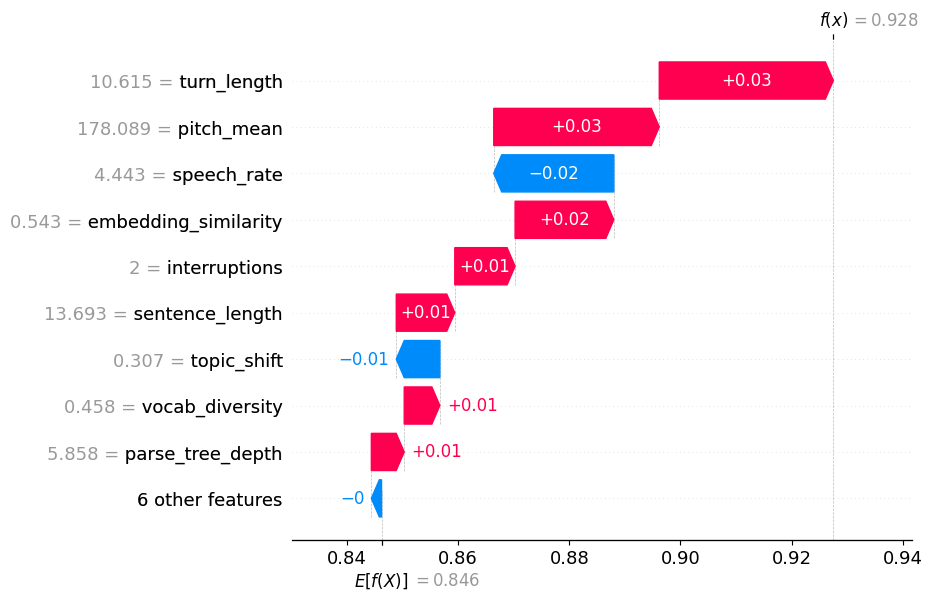

 98%|===================| 197/200 [00:11<00:00]       

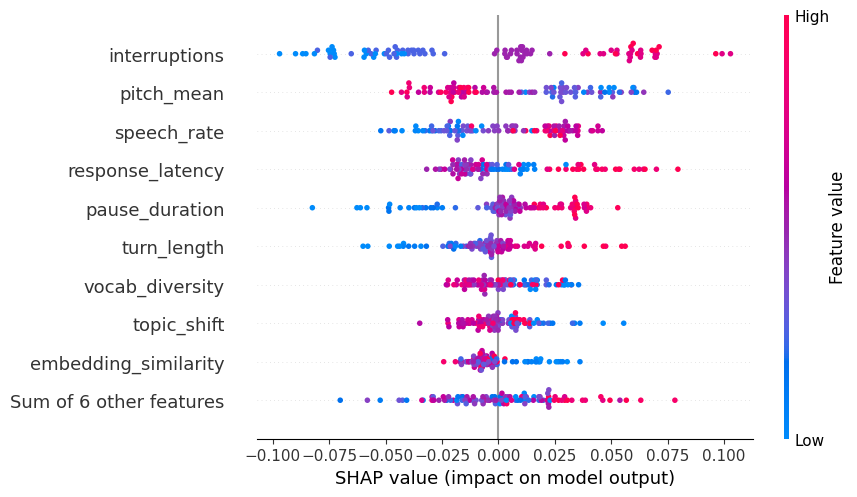

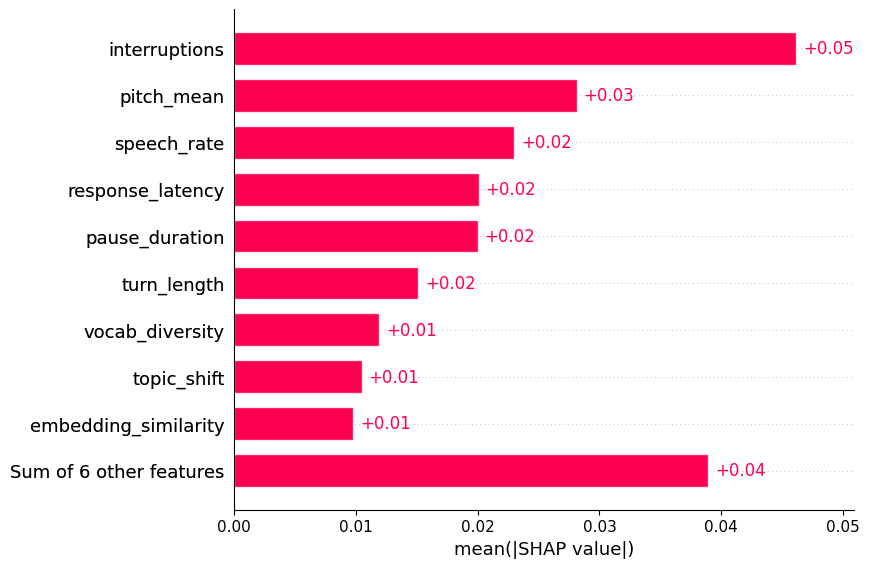

In [4]:

background = shap.sample(X_train, 100, random_state=42)
explainer = shap.TreeExplainer(clf, data=background)

# Single case explanation
case = X_test.iloc[[0]]
shap_values = explainer(case)

print("ASD Probability:", clf.predict_proba(case)[0][1])

# Waterfall (ASD class = 1)
shap.plots.waterfall(shap_values[0, :, 1])

# Global importance (ASD class)
shap_values_global = explainer(X_test)
shap.plots.beeswarm(shap_values_global[:,:,1])
shap.plots.bar(shap_values_global[:,:,1])



TRAIN AUTOENCODER (UNSUPERVISED)

In [5]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "models/ae_scaler.pkl")

input_dim = X_scaled.shape[1]
encoding_dim = 16

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='linear')(encoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(
    X_scaled, X_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

autoencoder.save("models/autoencoder.h5")



Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 1.6620 - val_loss: 1.4630
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4837 - val_loss: 1.3495
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.4278 - val_loss: 1.2562
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 1.2883 - val_loss: 1.1808
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2307 - val_loss: 1.1162
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 1.1554 - val_loss: 1.0635
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0860 - val_loss: 1.0175
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0253 - val_loss: 0.9761
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0281 - val_loss: 0.9399
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9663 - val_loss: 0.9075
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9308 - val_loss: 0.8783
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8

VALIDATE AUTOENCODER

In [6]:

X_reconstructed = autoencoder.predict(X_scaled, verbose=0)
reconstruction_errors = np.mean((X_scaled - X_reconstructed)**2, axis=1)
threshold = np.mean(reconstruction_errors) + 2*np.std(reconstruction_errors)
print("Autoencoder error threshold:", threshold)

def reconstruction_error(sample):
    x_scaled = scaler.transform(sample.reshape(1,-1))
    x_recon = autoencoder.predict(x_scaled, verbose=0)
    return np.mean((x_scaled - x_recon)**2)

def is_plausible(sample):
    return reconstruction_error(sample) < threshold

# Test
sample = X.iloc[0].values
tampered = sample.copy()
tampered[3] = -5  # unrealistic pause duration
print("Original plausible?", is_plausible(sample))
print("Tampered plausible?", is_plausible(tampered))



Autoencoder error threshold: 0.6987181434619043
Original plausible? True
Tampered plausible? False


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


COUNTERFACTUAL GENERATION + FILTERING

In [7]:

import dice_ml
from dice_ml import Dice

d = dice_ml.Data(dataframe=pd.concat([X, y], axis=1),
                 continuous_features=X.columns.tolist(),
                 outcome_name='label')

m = dice_ml.Model(model=clf, backend='sklearn')
exp = Dice(d, m, method="random")

query_instance = X_test.iloc[[0]]
dice_exp = exp.generate_counterfactuals(query_instance,
                                        total_CFs=5,
                                        desired_class="opposite")

cf_df = dice_exp.cf_examples_list[0].final_cfs_df
print("Generated counterfactuals:")
print(cf_df.head())

# Apply Autoencoder filtering
def filter_counterfactuals(cf_df):
    plausible = []
    for _, row in cf_df.iterrows():
        if is_plausible(row.values):
            plausible.append(row)
    return pd.DataFrame(plausible)

plausible_cfs = filter_counterfactuals(cf_df)
print("Filtered (plausible) counterfactuals:")
print(plausible_cfs)

plausible_cfs.to_csv("results/valid_counterfactuals.csv", index=False)
print("Valid CFs saved to /results/valid_counterfactuals.csv")

100%|██████████| 1/1 [00:01<00:00,  1.04s/it]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 01 sec


UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.